<a href="https://colab.research.google.com/github/vrathi101/SIGCOMMInclusivity/blob/main/SIGCOMMInclusivityFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and import necessary Python libraries for subsequent code.
1. Fuzzywuzzy is used for string matching (comparing strings which aren't identical but may have differences caused by typos, abbreviations, etc.). I used this when there weren't exact matches between the committee member dataframe and the researchers csv.
2. Levenshtein is used to measure the "distance" between strings which will be used for fuzzy comparing.
3. Beautifulsoup4 is used for webscraping. I used webscraping to extract the committee members for each year for SIGCOMM.
4. Gender-guesser is used to guess the gender of a person based on their first name. It have 6 possible outputs: 'male', 'mostly_male', 'female', 'mostly_female', 'andy', and 'unknown'. I used this for the names which had a fuzzy ratio of less than the fixed threshold when compared to every name in the researchers csv.
5. Unidecode is used to turn weird characters, like letters with accents or unprintable characters, into regular ones to make it easier for matching.


In [25]:
#install all packages
!pip install fuzzywuzzy
!pip install levenshtein
!pip install requests beautifulsoup4
!pip install gender-guesser
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import all of the libraries we will be using.

In [26]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import gender_guesser.detector as gender_detector
from unidecode import unidecode

Using webscraping to extract all the organizational committee and program committee members for SIGCOMM from 2014-2023, inclusive, and then adding all the names, categorized by year and committee type, into a dataframe.

In [28]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Create an empty DataFrame with columns for name, year, and committee
dfFinal = pd.DataFrame(columns=['name', 'year', 'committee'])

# Loop through the years 2009-2023
for year in range(2009, 2024):
  # Determine the URL based on the year
  if year >= 2012:
    if year in [2016, 2014, 2013, 2012]:
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/organization.php"
    elif year == 2015:
      url = "https://conferences.sigcomm.org/sigcomm/2015/organisation.php"
    else:
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/org-committee.html"
    # Send a GET request to the URL and retrieve the response
    response = requests.get(url)
    # Create a BeautifulSoup object to parse the HTML response
    soup = BeautifulSoup(response.text, "html.parser")
    # Select the HTML elements that contain the names of committee members
    name_elements = soup.select('div.ui-grid-a div.ui-block-a p')
    # Extract the names from the HTML elements and strip any whitespace
    names = [name.text.strip() for name in name_elements]
    # Create a DataFrame with the extracted names
    df = pd.DataFrame(names)
    # Add columns for the year and committee type
    df['year'] = year
    df['committee'] = 'Organizing'
    # Rename the column to 'name'
    df = df.rename(columns={df.columns[0]: 'name'})
    # Concatenate the current DataFrame with the final DataFrame
    dfFinal = pd.concat([dfFinal, df], ignore_index=False)
  elif year in [2011, 2010, 2009]:
        # Create the URL with the specified year
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/organization.php"

        # Send a GET request to the URL and retrieve the response
      response = requests.get(url)
        # Create a BeautifulSoup object to parse the HTML response
      soup = BeautifulSoup(response.text, "html.parser")

        # Find the <div> element with the id "contents"
      contents_div = soup.find("div", id="contents")
      if contents_div:
          if year == 2010:
                # Find the <h2> element with the text "Organizing Committee"
              committee_header = contents_div.find("h2", string="Organizing Committee")
          else:
                # Find the <h2> element with the text "Committee"
              committee_header = contents_div.find("h2", string="Committee")

          if committee_header:
                # Find the table following the <h2> element
              committee_table = committee_header.find_next_sibling("table")
              if committee_table:
                    # Find all <tr> elements within the table's <tbody>
                  committee_members = committee_table.find_all("tr")
                  for member in committee_members:
                        # Find the first <td> element within each <tr>
                      name_cell = member.find("td")
                      if name_cell:
                          member_name = name_cell.get_text(strip=True)
                            # Add the name to the final DataFrame
                          df = pd.DataFrame({'name': [member_name], 'year': [year], 'committee': ['Organizing']})
                          dfFinal = pd.concat([dfFinal, df], ignore_index=True)

# Print the final DataFrame
print(dfFinal)


                         name  year   committee
0             Pablo Rodriguez  2009  Organizing
1              Ernst Biersack  2009  Organizing
2   Konstantina  Papagiannaki  2009  Organizing
3                 Luigi Rizzo  2009  Organizing
4             Christophe Diot  2009  Organizing
..                        ...   ...         ...
16                   Jia Wang  2023  Organizing
17           Maria Apostolaki  2023  Organizing
18          Vishal Shrivastav  2023  Organizing
19             Lachlan Andrew  2023  Organizing
20                  Feng Qian  2023  Organizing

[423 rows x 3 columns]


In [29]:
# Loop through the years 2009-2023
for year in range(2009, 2024):
  if year >= 2012:
    # Determine the URL based on the year
    if year in [2016, 2015, 2014]:
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/pc.php"
    elif year in [2013, 2012]:
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/pclist.php"
    else:
      url = f"https://conferences.sigcomm.org/sigcomm/{year}/tpc.html"

    # Send a GET request to the URL and retrieve the response
    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML response
    soup = BeautifulSoup(response.text, "html.parser")

    # Select the HTML elements that contain the names of committee members
    name_elements = soup.select('div.ui-grid-a div.ui-block-a p')

    # Extract the names from the HTML elements and strip any whitespace
    names = [name.text.strip() for name in name_elements]

    # Create a DataFrame with the extracted names
    df = pd.DataFrame(names)

    # Add columns for the year and committee type
    df['year'] = year
    df['committee'] = 'Program'

    # Rename the column to 'name'
    df = df.rename(columns={df.columns[0]: 'name'})

    # Concatenate the current DataFrame with the final DataFrame
    dfFinal = pd.concat([dfFinal, df], ignore_index=False)
  else:
    # Create the URL with the specified year
    url = f"https://conferences.sigcomm.org/sigcomm/{year}/organization.php"

    # Send a GET request to the URL and retrieve the response
    response = requests.get(url)
    # Create a BeautifulSoup object to parse the HTML response
    soup = BeautifulSoup(response.text, "html.parser")

    # Find the <div> element with the id "contents"
    contents_div = soup.find("div", id="contents")
    if contents_div:
        if year == 2010:
            # Find the <h2> element with the text "Organizing Committee"
            committee_header = contents_div.find("h2", string="Technical Program Committee")
        else:
            # Find the <h2> element with the text "Committee"
            committee_header = contents_div.find("h2", string="Program Committee")

        if committee_header:
            # Find the table following the <h2> element
            committee_table = committee_header.find_next_sibling("table")
            if committee_table:
                # Find all <tr> elements within the table's <tbody>
                committee_members = committee_table.find_all("tr")
                for member in committee_members:
                    # Find the first <td> element within each <tr>
                    name_cell = member.find("td")
                    if name_cell:
                        member_name = name_cell.get_text(strip=True)
                        # Add the name to the final DataFrame
                        df = pd.DataFrame({'name': [member_name], 'year': [year], 'committee': ['Program']})
                        dfFinal = pd.concat([dfFinal, df], ignore_index=True)


# Print the final DataFrame
print(dfFinal)


                         name  year   committee
0             Pablo Rodriguez  2009  Organizing
1              Ernst Biersack  2009  Organizing
2   Konstantina  Papagiannaki  2009  Organizing
3                 Luigi Rizzo  2009  Organizing
4             Christophe Diot  2009  Organizing
..                        ...   ...         ...
56                 Yiting Xia  2023     Program
57               Yiying Zhang  2023     Program
58                     Yu Hua  2023     Program
59                 Yunxin Liu  2023     Program
60              Zhizhen Zhong  2023     Program

[1246 rows x 3 columns]


In [30]:
dfFinal.reset_index(drop=True, inplace=True)
print(dfFinal.groupby(['committee'])['committee'].count())

committee
Organizing    423
Program       823
Name: committee, dtype: int64


Importing the Researchers CSV with manually curated researcher data for many committees, including SIGCOMM.

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')
proj_path = '/content/gdrive/MyDrive/Colab Notebooks/save_data/'
researchers = pd.read_csv(proj_path + 'researchers.csv')
researchers['Region'] = researchers['Region'].fillna('NA')
researchers.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Name,Google Scholar Link,email,Institution,Expertise,Region,Approximate PhD Graduation Year,Female or NB,Minority (Race if known),Industry
0,Sergey Gorinsky,NaN,sergey.gorinsky@imdea.org,IMDEA,"CDN,CLOUD-DC,ECONOMICS,",EU,senior,NaN,NaN,NaN
1,Hitesh Ballani,NaN,hitesh.ballani@microsoft.com,Microsoft Research,"CLOUD-DC,ROUTING,",EU,senior,NaN,NaN,NaN
2,Haya Shulman,NaN,haya.shulman@sit.fraunhofer.de,Fraunhofer and Hebrew university of Jerusalem,"SECURITY,",EU,NaN,1.0,NaN,1.0
3,Rüdiger Birkner,NaN,mail@rbirkner.ch,???,"SDN,",EU,2018,NaN,NaN,NaN
4,Klaus Wehrle,NaN,wehrle@comsys.rwth-aachen.de,Aachen University,"VERIFICATION,SECURITY,",EU,senior,NaN,NaN,NaN


Extracting the needed columns from researchers dataframe and changing Gender column from numbers/nulls to string values. Making adjustments to the columns of both dataframes to simplify matching process.

In [32]:
# Specify the columns to extract from the 'researchers' DataFrame
columns_to_extract =['Name','Female or NB', 'Region']

# Create a new DataFrame 'dfResearch' with the selected columns
dfResearch = researchers[columns_to_extract]

# Rename the column 'Female or NB' to 'Gender'
dfResearch.rename(columns={'Female or NB': 'Gender'}, inplace=True)

# Replace NaN values and 1.0 values in the 'Gender' column
dfResearch['Gender'] = dfResearch['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})

# Apply the 'unidecode' function to create the 'refined_name' column in 'dfResearch'
dfResearch['refined_name'] = researchers['Name'].apply(unidecode)

# Apply the 'unidecode' function to create the 'refined_name' column in 'dfFinal'
dfFinal['refined_name'] = dfFinal['name'].apply(unidecode)

# Rename the 'name' column to 'Name' in 'dfFinal'
dfFinal = dfFinal.rename(columns={'name': 'Name'})


<ipython-input-32-9c27191a3475>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearch.rename(columns={'Female or NB': 'Gender'}, inplace=True)
<ipython-input-32-9c27191a3475>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfResearch['Gender'] = dfResearch['Gender'].replace({float('Nan'): 'Male', 1.0: 'Female'})
<ipython-input-32-9c27191a3475>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Adding columns to dfFinal (original) dataframe by merging it with dfResearch dataframe based on the full name of a committee member, the refined full name, a fuzzy match, and gender guesser.

In [33]:
dfFinal['GenderPython']=''
def guess_gender(first_name):
    # Initialize gender detector
    d = gender_detector.Detector()
    # Get the gender of the first name
    gender = d.get_gender(first_name)
    return gender
for idx, row in dfFinal.iterrows():
  Name = row['Name']
  gender=guess_gender(Name.split()[0])
  dfFinal.loc[idx, 'GenderPython'] = gender
#creating a GenderPython column in dfFinal which has values representing the outputs of the function for each name
print(dfFinal.groupby(['GenderPython'])['GenderPython'].count())
print()


# Merge the two DataFrames based on the 'name' column
dfResearch = dfResearch.drop_duplicates(subset='Name', keep='first')
dfFinal['GenderFullNameMatch']=''
merged_df = dfFinal.merge(dfResearch, on='Name', how='left')
merged_df['GenderFullNameMatch']=merged_df['GenderFullNameMatch'].replace('',np.nan)
merged_df['GenderFullNameMatch'].fillna(merged_df['Gender'], inplace=True)
merged_df.rename(columns={'refined_name_x':'refined_name'}, inplace=True)
dfFinalUpdated = merged_df[['Name','GenderPython', 'GenderFullNameMatch','refined_name', 'committee','year', 'Region']]
print(dfFinalUpdated.groupby(['GenderFullNameMatch'])['GenderFullNameMatch'].count())
print()

# Merge the two DataFrames based on the 'refined_name' column
dfFinalUpdated['GenderPartialNameMatch']=''
merged_df = dfFinalUpdated.merge(dfResearch, on='refined_name', how='left')
merged_df['GenderPartialNameMatch']=merged_df['GenderPartialNameMatch'].replace('',np.nan)
merged_df['GenderPartialNameMatch'].fillna(merged_df['Gender'], inplace=True)
merged_df.rename(columns={'Name_x':'Name'}, inplace=True)
merged_df['Region_x'].fillna(merged_df['Region_y'], inplace=True)
merged_df.rename(columns={'Region_x':'Region'}, inplace=True)
dfFinalUpdated02 = merged_df[['Name','GenderPython', 'GenderFullNameMatch','GenderPartialNameMatch', 'Region', 'refined_name', 'committee','year']]
dfFinalUpdated02["Gender"]=''
dfFinalUpdated02["Source"]=''
print(dfFinalUpdated.groupby(['GenderPartialNameMatch'])['GenderPartialNameMatch'].count())
print()

#Using fuzzy matching to add a new column to the dfFinalUpdated02 dataframe and again checking for additional Region matches
dfFinalUpdated02['FuzzyMatching'] = ''
for idx, row in dfFinalUpdated02.iterrows():
    name_updated = row['refined_name']
    best_match = None
    best_score = 0
    for _, research_row in dfResearch.iterrows():
        name_research = research_row['refined_name']
        score = fuzz.token_set_ratio(name_updated, name_research)
        if score > best_score and score > 90:
            best_match = research_row['Gender']
            best_match_Region = research_row['Region']
            best_score = score
        if score == 100:  # If perfect match, break the loop
            break
    dfFinalUpdated02.loc[idx, 'FuzzyMatching'] = best_match
    dfFinalUpdated02.loc[idx, 'Region']=best_match_Region
print(dfFinalUpdated02.groupby(['FuzzyMatching'])['FuzzyMatching'].count())
print()
print(dfFinalUpdated02.groupby(['Region'])['Region'].count())
print()

#print a few rows of the adjusted dataframe#
print(dfFinalUpdated02.head())

GenderPython
andy              71
female           180
male             639
mostly_female     15
mostly_male       23
unknown          318
Name: GenderPython, dtype: int64

GenderFullNameMatch
Female    182
Male      670
Name: GenderFullNameMatch, dtype: int64

GenderPartialNameMatch
    1246
Name: GenderPartialNameMatch, dtype: int64



<ipython-input-33-a5b424c6e753>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFinalUpdated['GenderPartialNameMatch']=''
<ipython-input-33-a5b424c6e753>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfFinalUpdated02["Gender"]=''
<ipython-input-33-a5b424c6e753>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

FuzzyMatching
Female    212
Male      800
Name: FuzzyMatching, dtype: int64

Region
Asia         120
Australia     13
EU           246
NA           858
SA             9
Name: Region, dtype: int64

                        Name GenderPython GenderFullNameMatch  \
0            Pablo Rodriguez         male                 NaN   
1             Ernst Biersack         male                 NaN   
2  Konstantina  Papagiannaki       female                 NaN   
3                Luigi Rizzo         male                Male   
4            Christophe Diot         male                Male   

  GenderPartialNameMatch Region               refined_name   committee  year  \
0                    NaN     EU            Pablo Rodriguez  Organizing  2009   
1                    NaN     EU             Ernst Biersack  Organizing  2009   
2                    NaN     NA  Konstantina  Papagiannaki  Organizing  2009   
3                   Male     EU                Luigi Rizzo  Organizing  2009   
4           

Filling in the dataframe Gender column based on the columns GenderFullNameMatch, GenderPartialNameMatch, FuzzyMatching, and GenderPython which receive priority in the order listed.

In [34]:
#GenderFullNameMatch checked first
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].replace('', np.nan)
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].fillna(dfFinalUpdated02['GenderFullNameMatch'])

#GenderPartialNameMatch checked second
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].fillna(dfFinalUpdated02['GenderPartialNameMatch'])
dfFinalUpdated02

#FuzzyMatching checked third
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].fillna(dfFinalUpdated02['FuzzyMatching'])
dfFinalUpdated02

#GenderPython checked last
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].fillna(np.nan)
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].fillna(dfFinalUpdated02['GenderPython'])
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].replace(['male', 'mostly_male'], 'Male')
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].replace(['female', 'mostly_female'], 'Female')
dfFinalUpdated02['Gender'] = dfFinalUpdated02['Gender'].replace(['andy', 'unknown'], 'Unknown')


Determining the method used to find gender based on which columns had empty values vs. non-empty values.

In [42]:
for index, row in dfFinalUpdated02.iterrows():
  # if column A is nonempty, fill in Source (method) with column A method name
  if not pd.isnull(row['GenderFullNameMatch']):
    dfFinalUpdated02.loc[index, 'Source'] = 'FullNameMatch'
  # if column A is empty and column B is nonempty, fill in Source (method) with column B method name
  elif pd.isnull(row['GenderFullNameMatch']) and not pd.isnull(row['GenderPartialNameMatch']):
    dfFinalUpdated02.loc[index, 'Source'] = 'PartialNameMatch'
  # if column A is empty, column B is empty and column C is nonempty, fill in Source with column C method name
  elif pd.isnull(row['GenderFullNameMatch']) and pd.isnull(row['GenderPartialNameMatch']) and row['FuzzyMatching'] is not None:
    dfFinalUpdated02.loc[index, 'Source'] = 'FuzzyMatching'
  # if column A is empty, column B is empty, column C is empty, fill in Source with column D method name
  else:
    dfFinalUpdated02.loc[index, 'Source'] = 'GenderGuesser'
pd.reset_option('display.max_rows')
dfFinalUpdated02

,Name,GenderPython,GenderFullNameMatch,GenderPartialNameMatch,Region,refined_name,committee,year,Gender,Source,FuzzyMatching
0,Pablo Rodriguez,male,NaN,NaN,EU,Pablo Rodriguez,Organizing,2009,Male,FuzzyMatching,Male
1,Ernst Biersack,male,NaN,NaN,EU,Ernst Biersack,Organizing,2009,Male,FuzzyMatching,Male
2,Konstantina Papagiannaki,female,NaN,NaN,NA,Konstantina Papagiannaki,Organizing,2009,Female,FuzzyMatching,Female
3,Luigi Rizzo,male,Male,Male,EU,Luigi Rizzo,Organizing,2009,Male,FullNameMatch,Male
4,Christophe Diot,male,Male,Male,NA,Christophe Diot,Organizing,2009,Male,FullNameMatch,Male
...,...,...,...,...,...,...,...,...,...,...,...
1241,Yiting Xia,unknown,Female,Female,EU,Yiting Xia,Program,2023,Female,FullNameMatch,Female
1242,Yiying Zhang,unknown,Female,Female,NA,Yiying Zhang,Program,2023,Female,FullNameMatch,Female
1243,Yu Hua,andy,NaN,NaN,NA,Yu Hua,Program,2023,Unknown,GenderGuesser,None
1244,Yunxin Liu,unknown,NaN,NaN,NA,Yunxin Liu,Program,2023,Unknown,GenderGuesser,None


Making charts showing the gender distribution for each of the 30 committees (two committee types, 15 years).

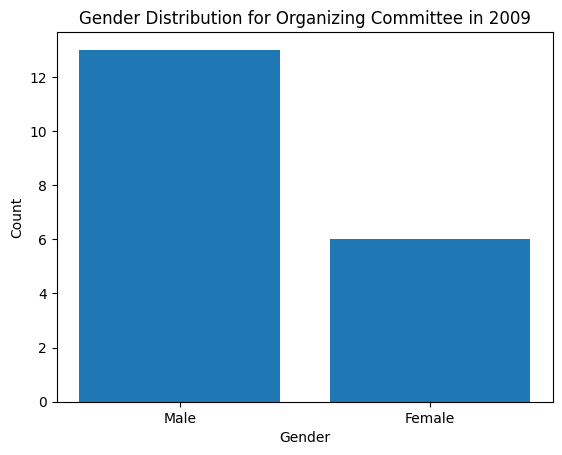

Names with unknown gender for Organizing Committee in 2009:
Jaudelice de Oliveira
Balachander Krishnamurthy



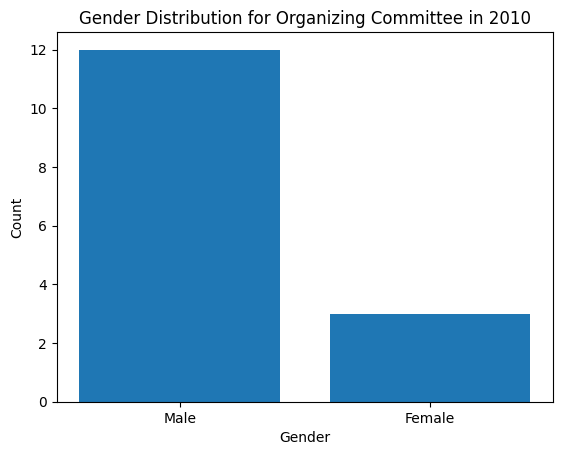

Names with unknown gender for Organizing Committee in 2010:
Shivkumar Kalyanaraman
Huzur Saran
Aaditeshwar Seth
Carla-Fabiana Chiasserini
Krishna Sivalingam
Partha Dutta
B.N. Jain
Anurag Kumar
Jaudelice de Oliveira



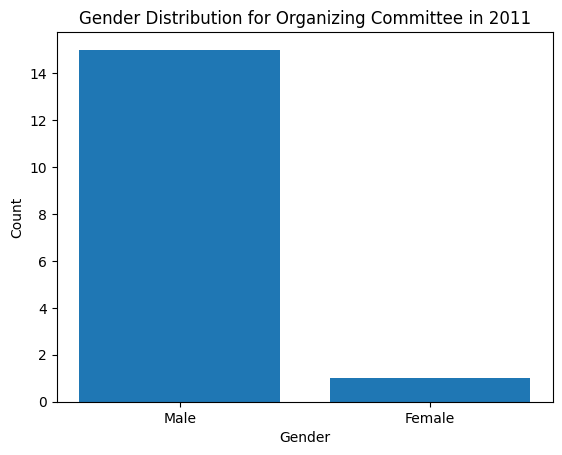

Names with unknown gender for Organizing Committee in 2011:
Jaudelice de Oliveira



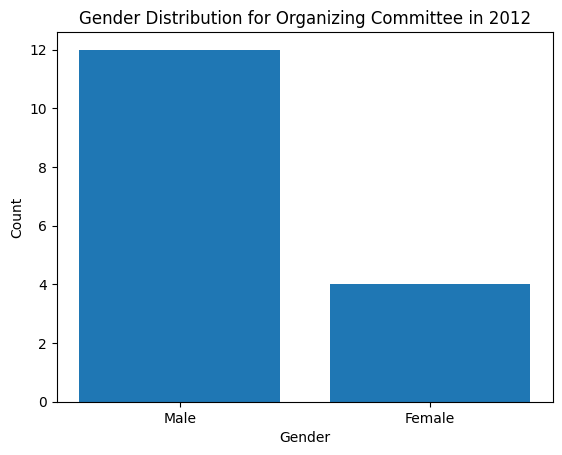

Names with unknown gender for Organizing Committee in 2012:
Liang Wang
Jaudelice de Oliveira



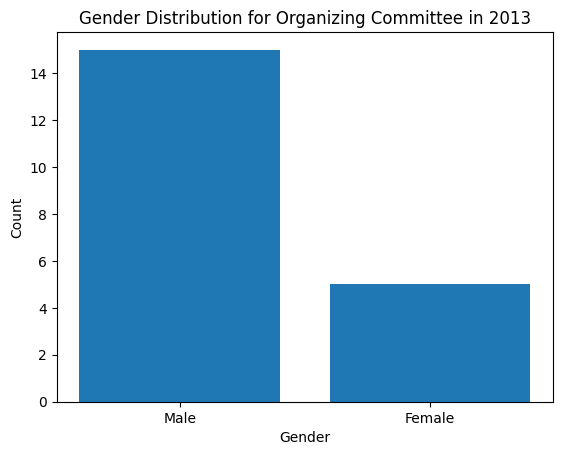

Names with unknown gender for Organizing Committee in 2013:
Xiaohua Jia
Wing Cheong Lau
Yongguang Zhang
Kwok Wai Cheung
Jaudelice de Oliveira



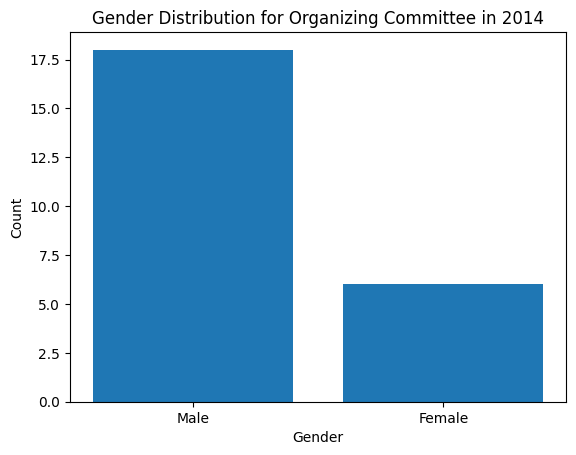

Names with unknown gender for Organizing Committee in 2014:
Bin Liu
Jaudelice de Oliveira



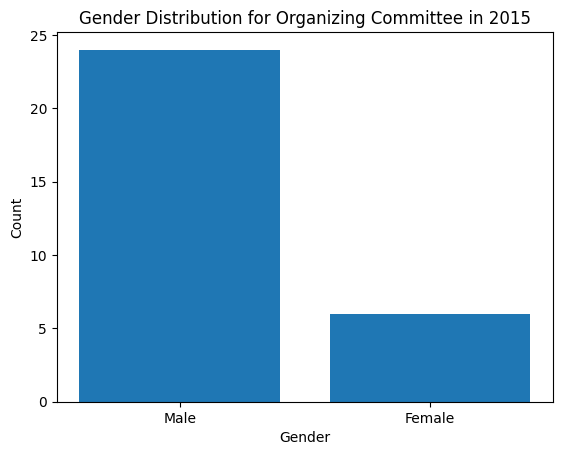

Names with unknown gender for Organizing Committee in 2015:
Cigdem Sengul
Gaogang Xie
Cigdem Sengul



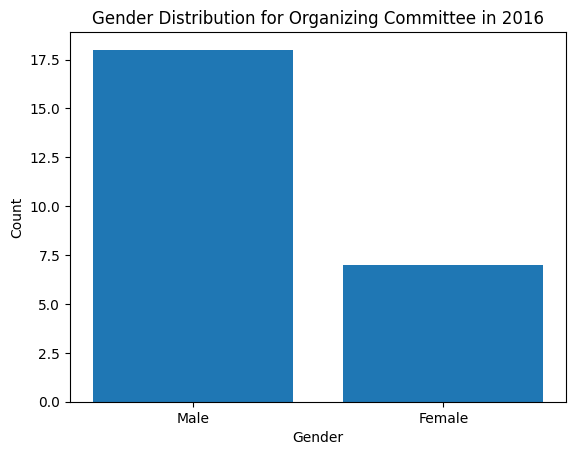

Names with unknown gender for Organizing Committee in 2016:
Fabíola Greve
Leobino Sampaio
Pan Hui
Aakanksha Chowdhery
Lisandro Z Granville
Weverton Cordeiro
Anna-Kaisa Pietilainen
Jussara Almeida



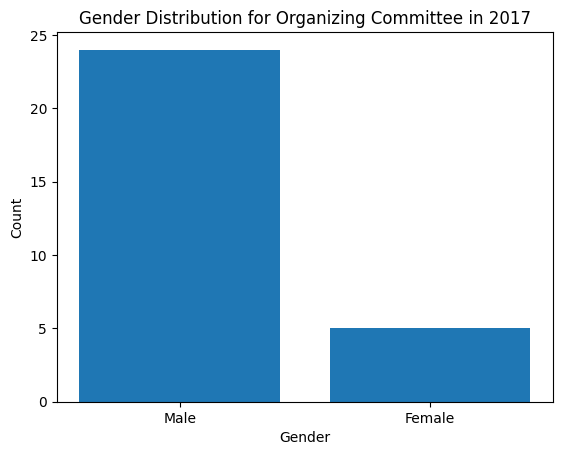

Names with unknown gender for Organizing Committee in 2017:
Bharathan Balaji
Mayutan Arumaithurai
Lan Wang
Vahab Pournaghshband



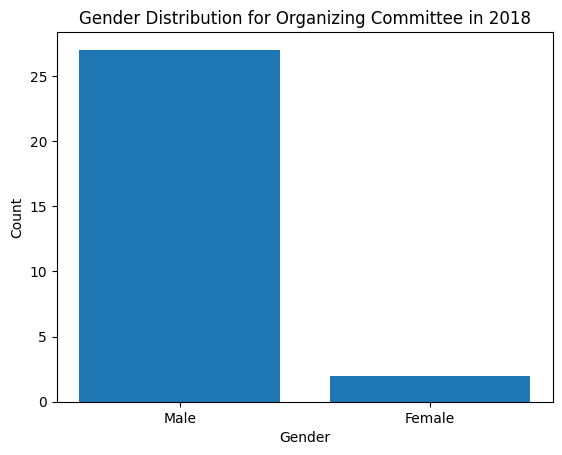

Names with unknown gender for Organizing Committee in 2018:
JÃ¡nos Tapolcai
BalÃ¡zs Sonkoly
AndrÃ¡s CsÃ¡szÃ¡r
GÃ¡bor RÃ©tvÃ¡ri
ZoltÃ¡n LÃ¡zÃ¡r
IstvÃ¡n GÃ³dor
ZalÃ¡n Heszberger
Jasleen Kaur
Pin-Han Ho



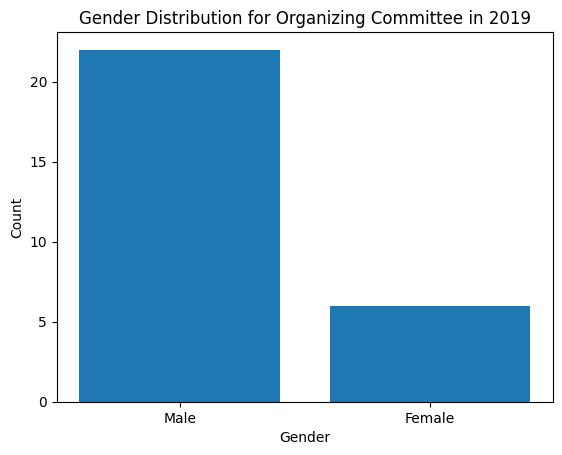

Names with unknown gender for Organizing Committee in 2019:
Xiangyang Li
Zhili Zhang
Gaogang Xie
JÃ¶rg Ott
Xia Yin
Xiaochun Yun
Ke Xu
Xiuzhen Cheng
Yanyong Zhang
Lan Wang
Hongbin Luo
Sheng Zhong
Huadong Ma
Junzhou Luo
Kui Ren
Jiangchuan Liu



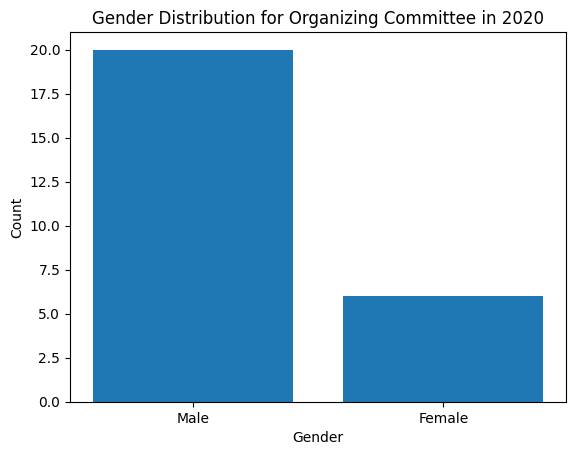

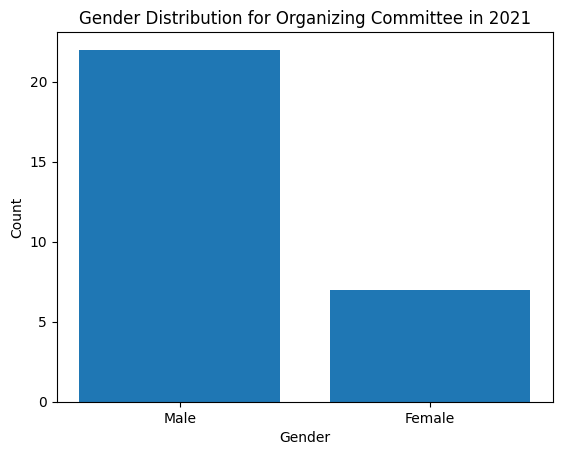

Names with unknown gender for Organizing Committee in 2021:
JÃ¶rg Ott
Pan Hui



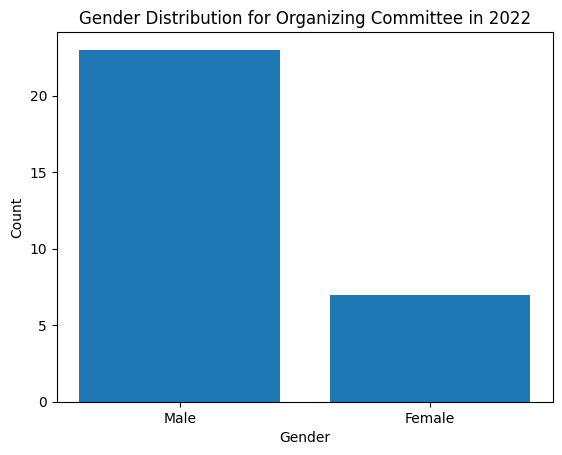

Names with unknown gender for Organizing Committee in 2022:
Pan Hui
Chen Qian
Jasleen Kaur



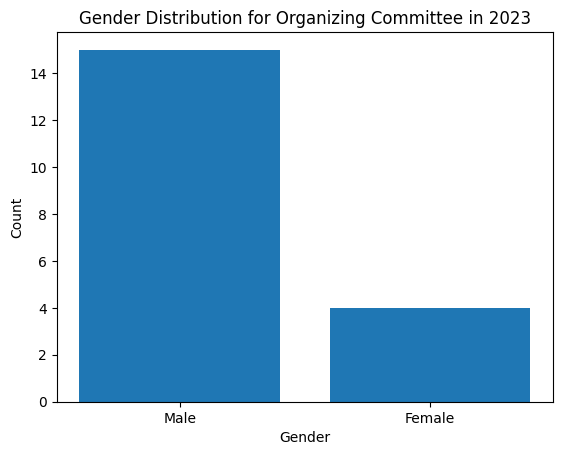

Names with unknown gender for Organizing Committee in 2023:
Kostis Kaffes
Minmei Wang



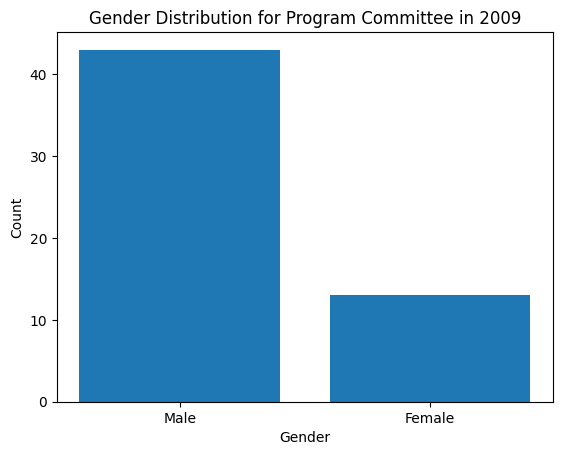

Names with unknown gender for Program Committee in 2009:
Saumitra Das
S Keshav
Himabindu Pucha
Amgad Zeitoun



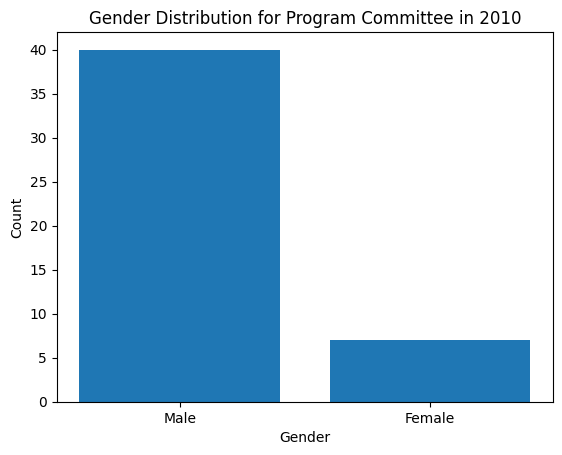

Names with unknown gender for Program Committee in 2010:
S. Keshav
Murali Kodialam
Yinglian Xie



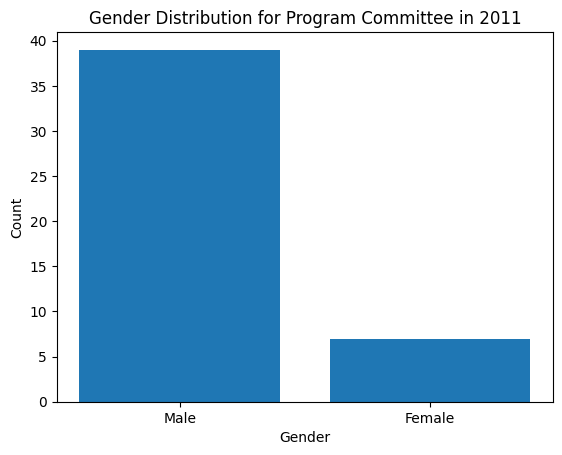

Names with unknown gender for Program Committee in 2011:
Balachander Krishnamurthy
Byrav Ramamurthy
Mema Roussopoulos
Devavrat Shah
Yinglian Xie
Yongguang Zhang



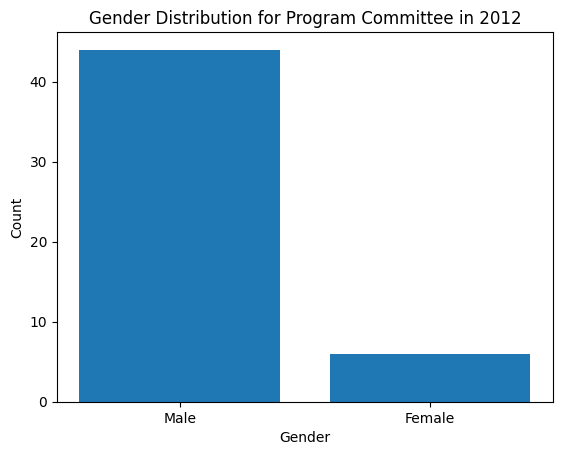

Names with unknown gender for Program Committee in 2012:
Hovav Shacham



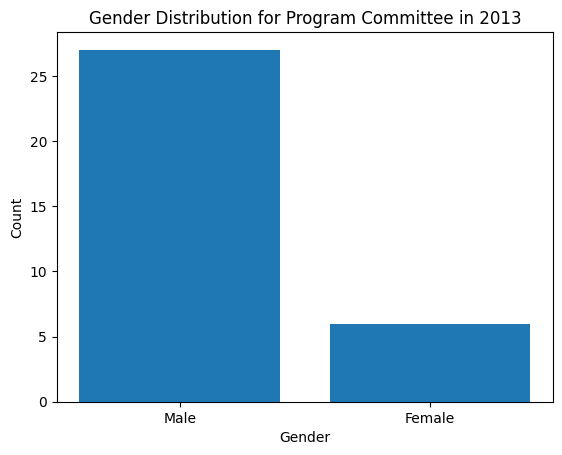

Names with unknown gender for Program Committee in 2013:
Shyamnath Gollakota
Jitu Padhye



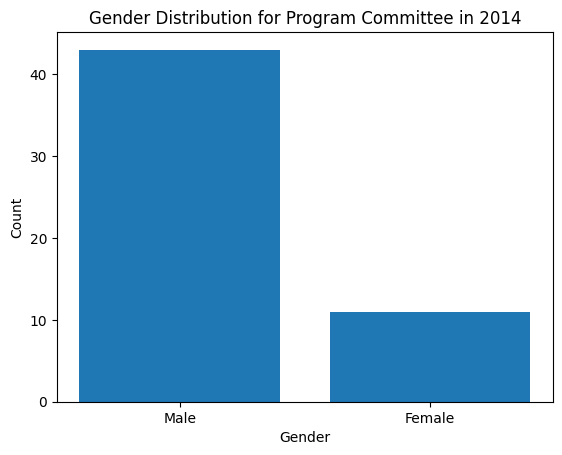

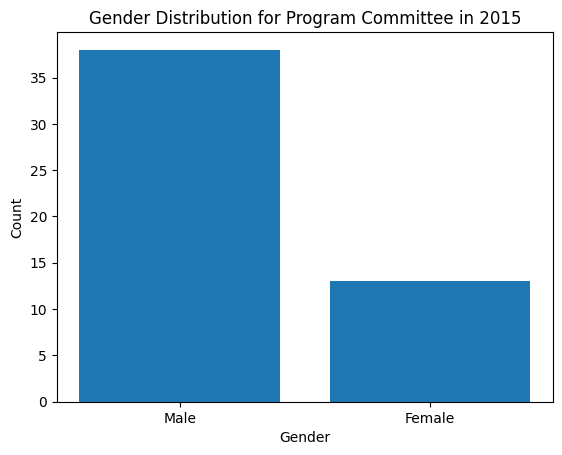

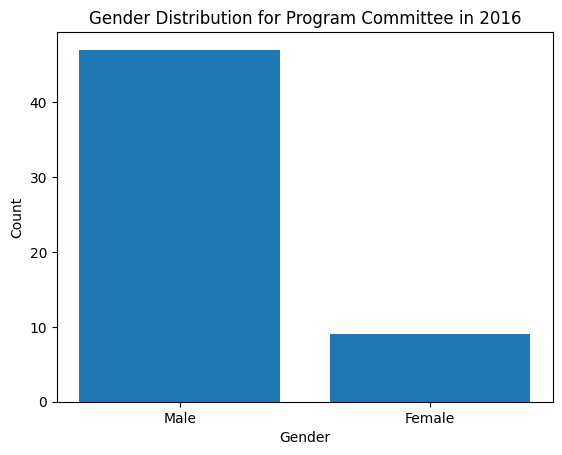

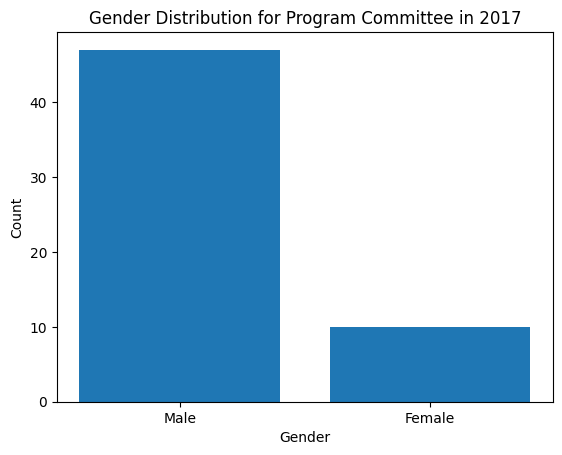

Names with unknown gender for Program Committee in 2017:
RubÃ©n Cuevas
Pat Bosshard



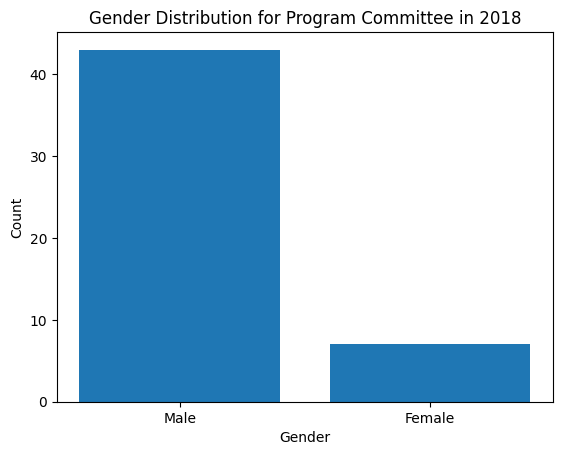

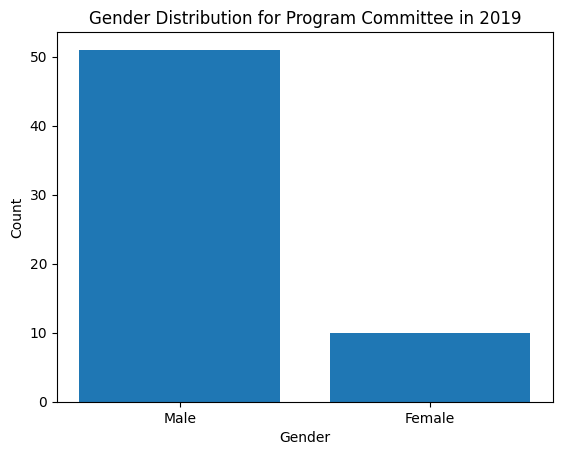

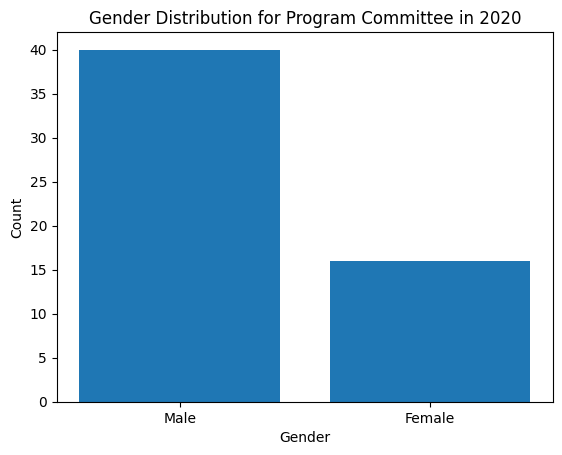

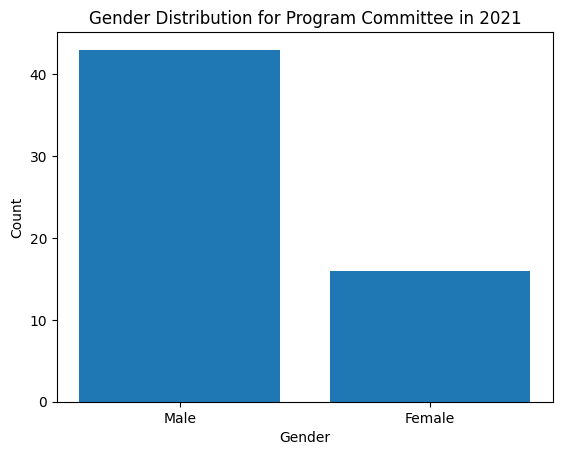

Names with unknown gender for Program Committee in 2021:
Jitu Padhye



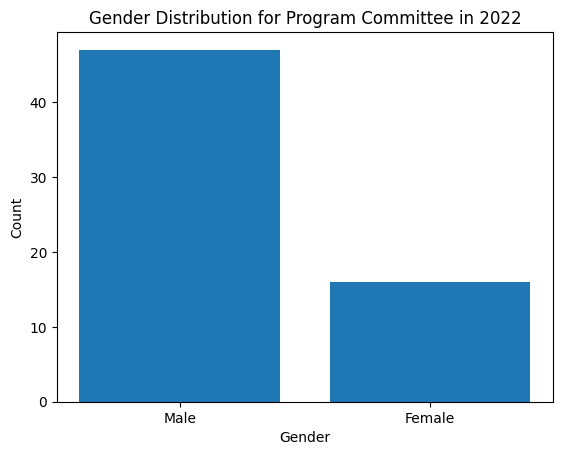

Names with unknown gender for Program Committee in 2022:
GÃ¡bor RÃ©tvÃ¡ri
Santhosh Prabhu
Shangtong Zhang
Yaxiong Xie



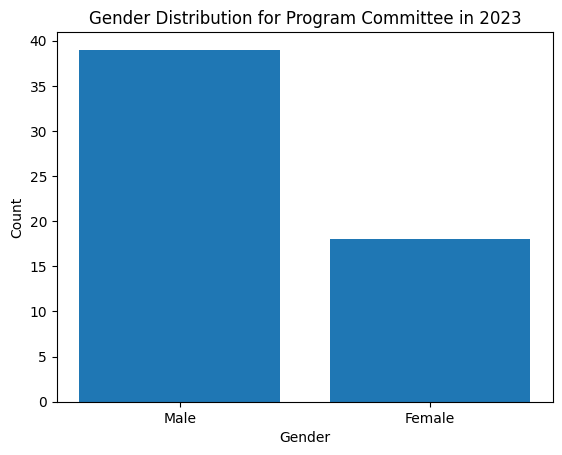

Names with unknown gender for Program Committee in 2023:
Heming Cui
Wen Hu
Yu Hua
Yunxin Liu



In [36]:
# Get unique committee and year values from the DataFrame
committees = dfFinalUpdated02['committee'].unique()
years = dfFinalUpdated02['year'].unique()

# Loop through each committee
for committee in committees:
    for year in years:
        # Filter the DataFrame for the current committee and year
        df_filtered = dfFinalUpdated02[(dfFinalUpdated02['committee'] == committee) & (dfFinalUpdated02['year'] == year)]

        # Calculate gender counts
        male_count = df_filtered[df_filtered['Gender'] == 'Male'].shape[0]
        female_count = df_filtered[df_filtered['Gender'] == 'Female'].shape[0]
        unknown_count = df_filtered[df_filtered['Gender'] == 'Unknown'].shape[0]

        # Create bar chart
        genders = ['Male', 'Female']
        counts = [male_count, female_count]

        plt.bar(genders, counts)
        plt.xlabel('Gender')
        plt.ylabel('Count')
        plt.title(f'Gender Distribution for {committee} Committee in {year}')
        plt.show()

        # Print names with unknown gender
        unknown_names = df_filtered[df_filtered['Gender'] == 'Unknown']['Name'].tolist()
        if len(unknown_names) > 0:
            print(f"Names with unknown gender for {committee} Committee in {year}:")
            for name in unknown_names:
                print(name)
            print()


Making a graph showing the changes of gender distribution (as a percentage and as a count) for each of the two committee types over the 15-year span.

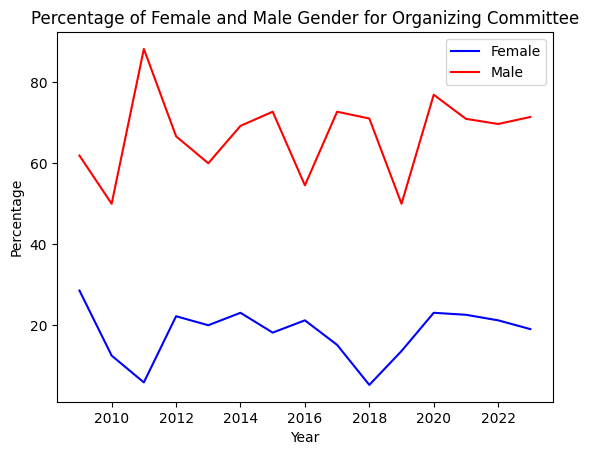

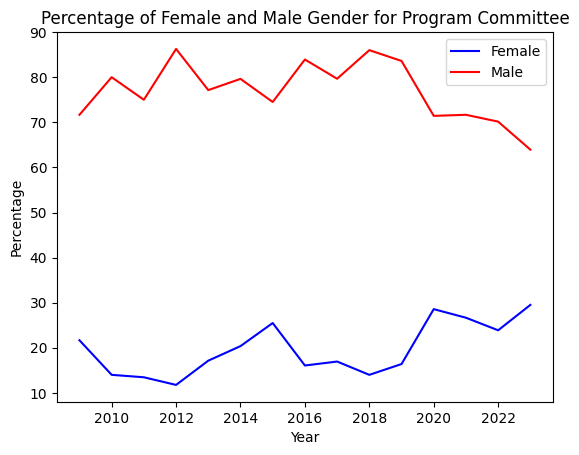

In [37]:
# Get unique committee types
committee_types = dfFinalUpdated02['committee'].unique()

# Iterate over committee types and create graphs
for committee_type in committee_types:
    # Select data for the specific committee type
    df_committee = dfFinalUpdated02[dfFinalUpdated02['committee'] == committee_type]

    # Calculate the percentage of Female and Male gender for each year
    female_percentages = []
    male_percentages = []
    years = range(2009, 2024)

    for year in years:
        df_year = df_committee[df_committee['year'] == year]
        female_percentage = (df_year[df_year['Gender'] == 'Female'].shape[0] / len(df_year)) * 100
        male_percentage = (df_year[df_year['Gender'] == 'Male'].shape[0] / len(df_year)) * 100
        female_percentages.append(female_percentage)
        male_percentages.append(male_percentage)

    # Create the plot
    plt.plot(years, female_percentages, color='blue', label='Female')
    plt.plot(years, male_percentages, color='red', label='Male')

    # Set plot title and labels
    plt.title(f"Percentage of Female and Male Gender for {committee_type} Committee")
    plt.xlabel("Year")
    plt.ylabel("Percentage")

    # Set plot legend
    plt.legend()

    # Display the plot
    plt.show()


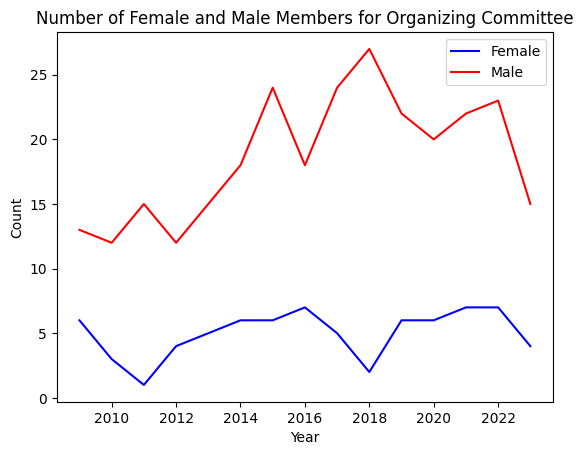

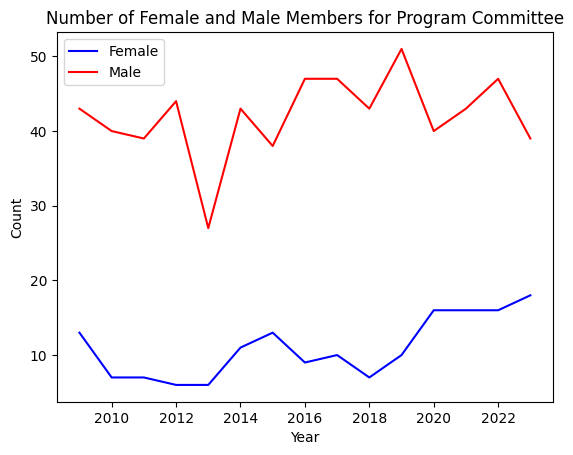

In [38]:
# Get unique committee types
committee_types = dfFinalUpdated02['committee'].unique()

# Iterate over committee types and create graphs
for committee_type in committee_types:
    # Select data for the specific committee type
    df_committee = dfFinalUpdated02[dfFinalUpdated02['committee'] == committee_type]

    # Calculate the number of Female and Male members for each year
    female_counts = []
    male_counts = []
    years = range(2009, 2024)

    for year in years:
        df_year = df_committee[df_committee['year'] == year]
        female_count = df_year[df_year['Gender'] == 'Female'].shape[0]
        male_count = df_year[df_year['Gender'] == 'Male'].shape[0]
        female_counts.append(female_count)
        male_counts.append(male_count)

    # Create the plot
    plt.plot(years, female_counts, color='blue', label='Female')
    plt.plot(years, male_counts, color='red', label='Male')

    # Set plot title and labels
    plt.title(f"Number of Female and Male Members for {committee_type} Committee")
    plt.xlabel("Year")
    plt.ylabel("Count")

    # Set plot legend
    plt.legend()

    # Display the plot
    plt.show()


Making charts and graphs showing the geographic distribution for each of the 30 committees (two committee types, 15 years).

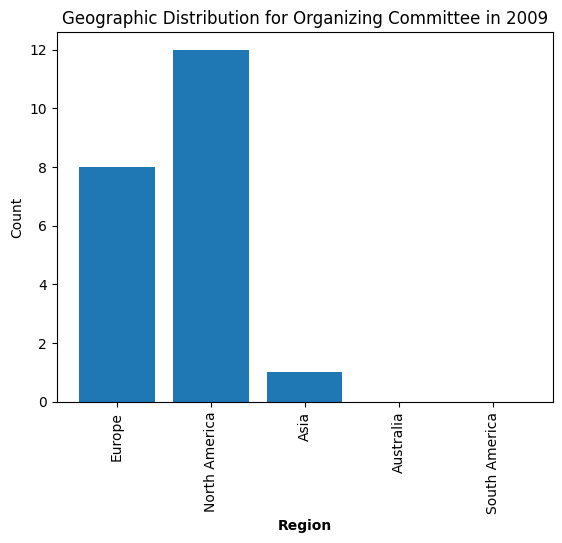

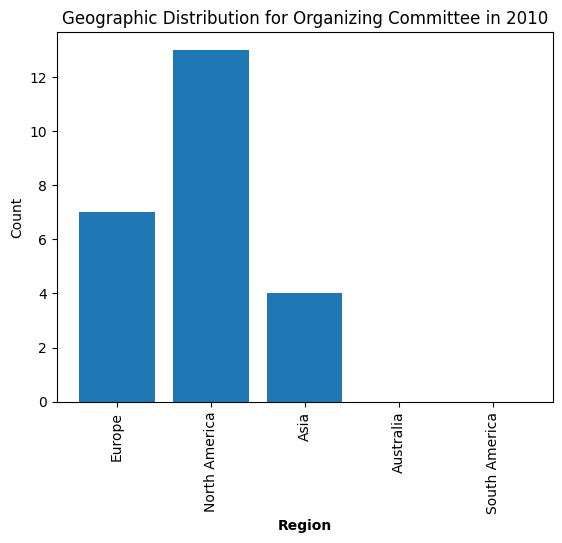

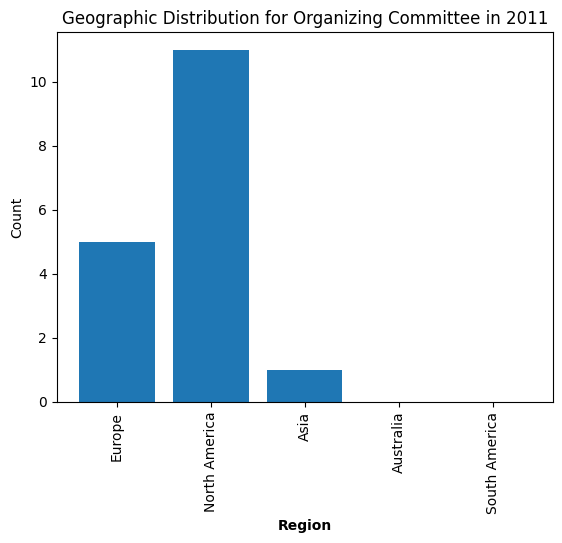

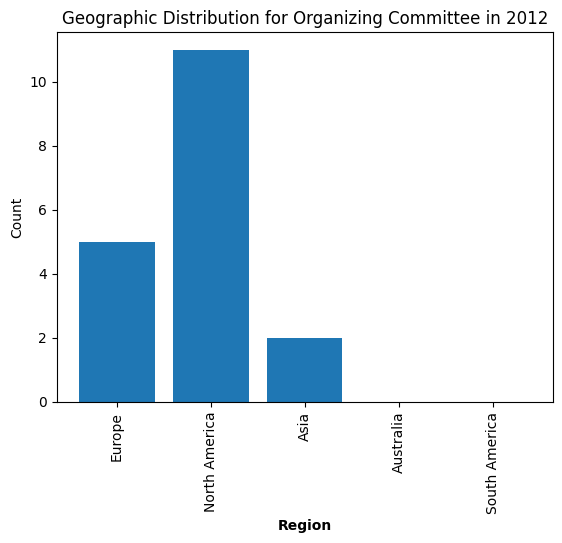

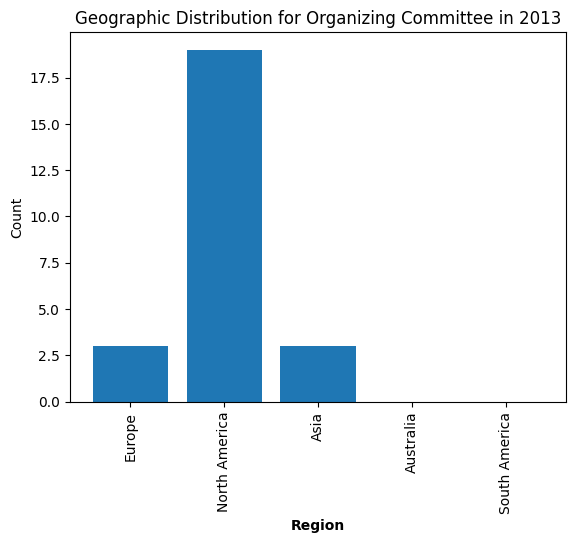

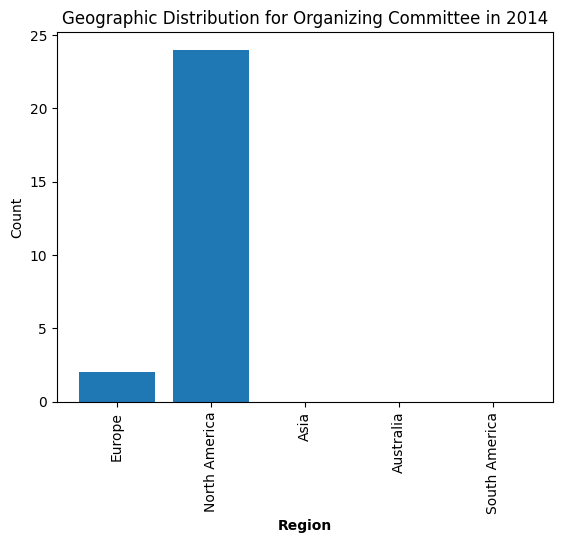

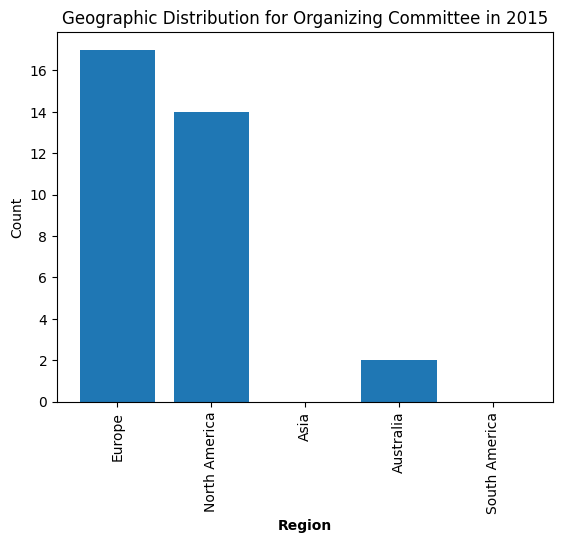

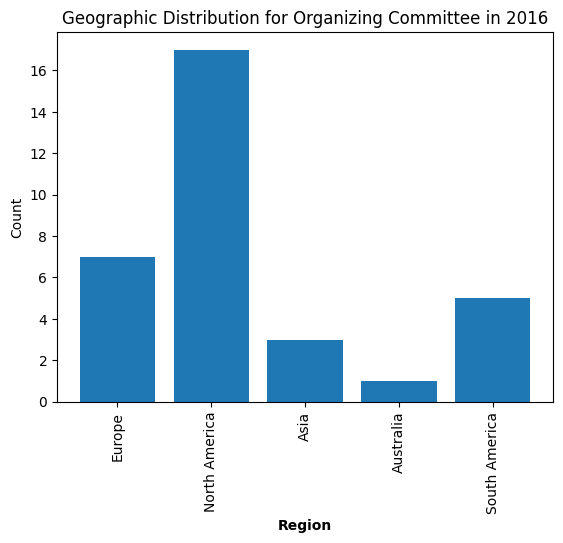

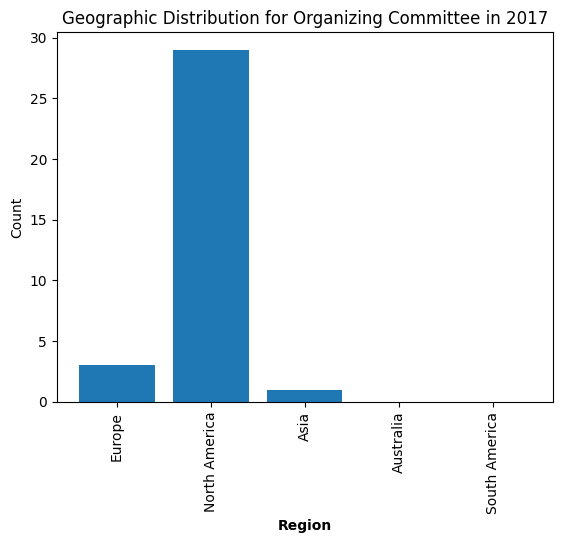

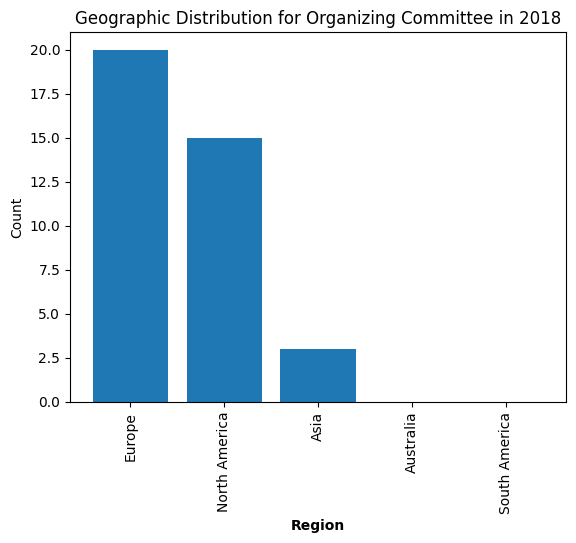

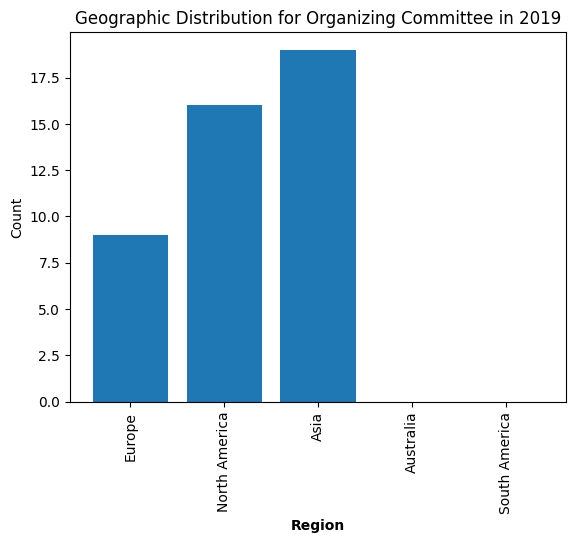

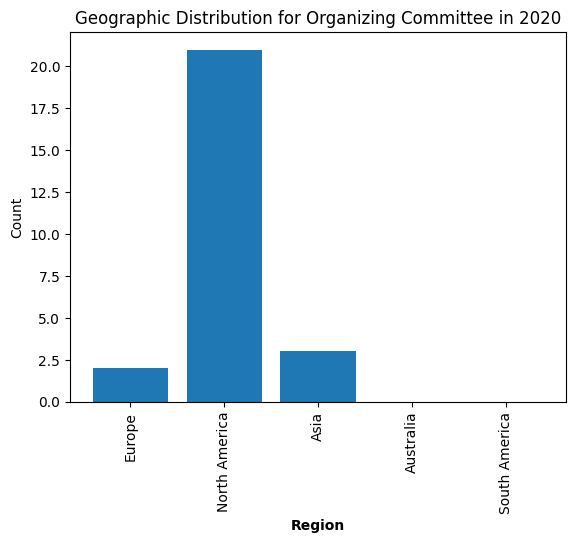

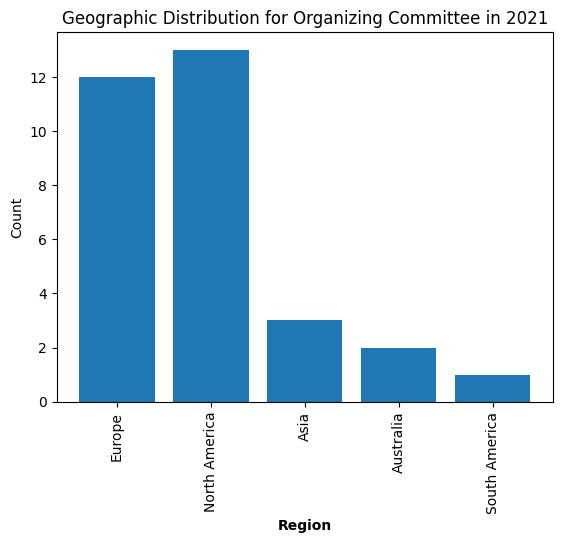

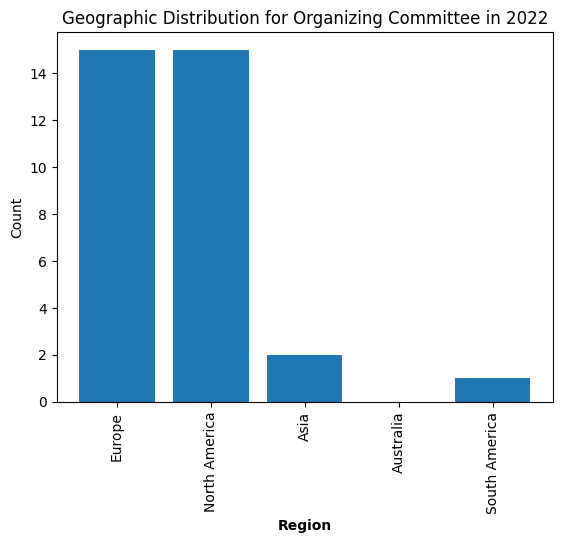

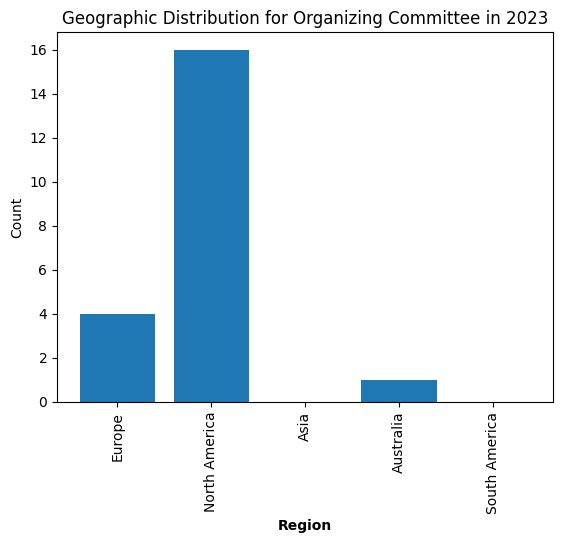

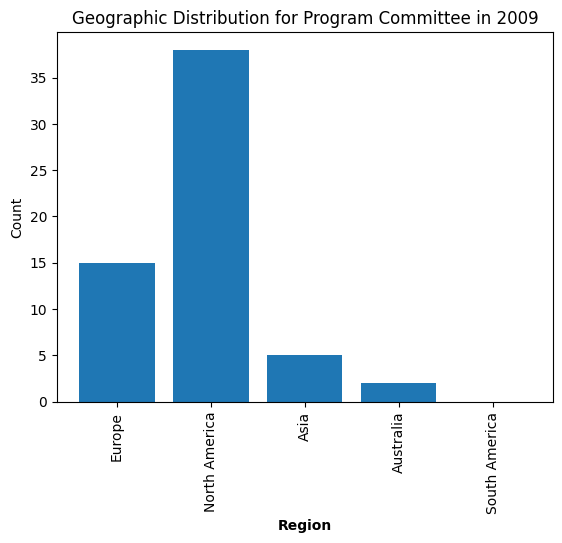

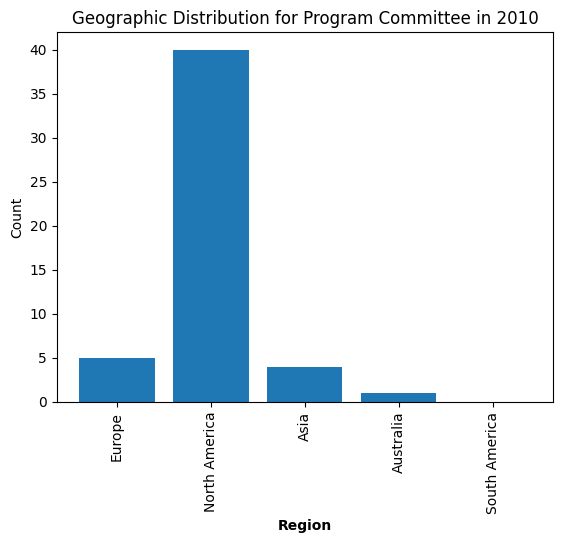

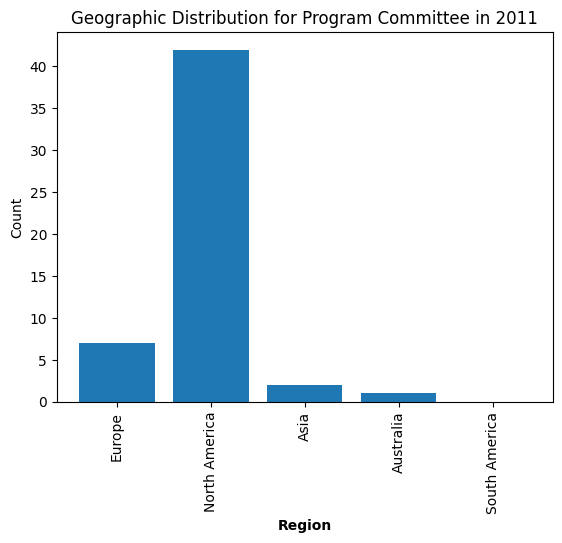

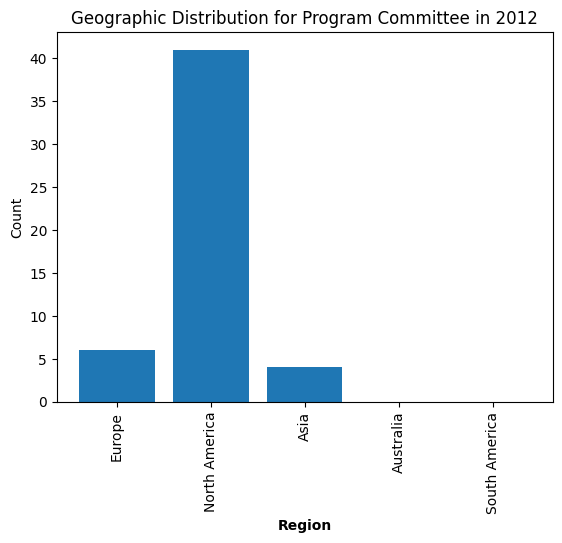

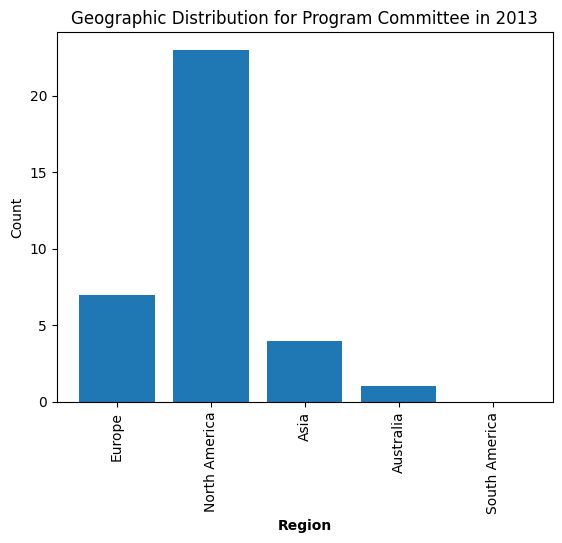

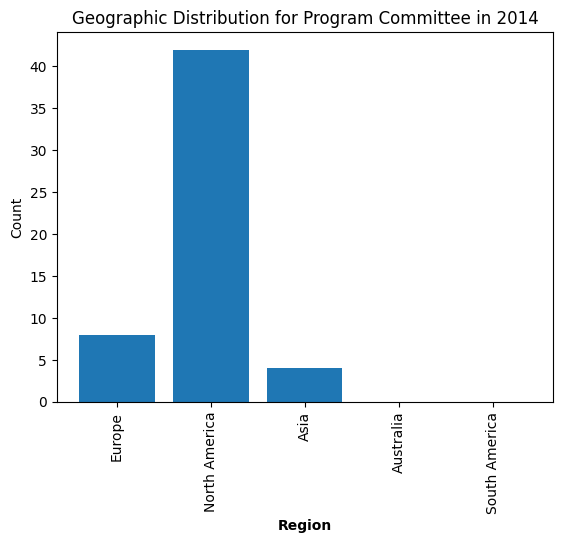

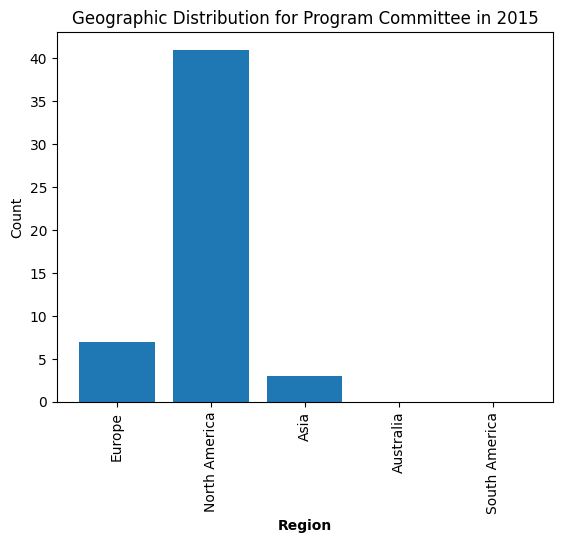

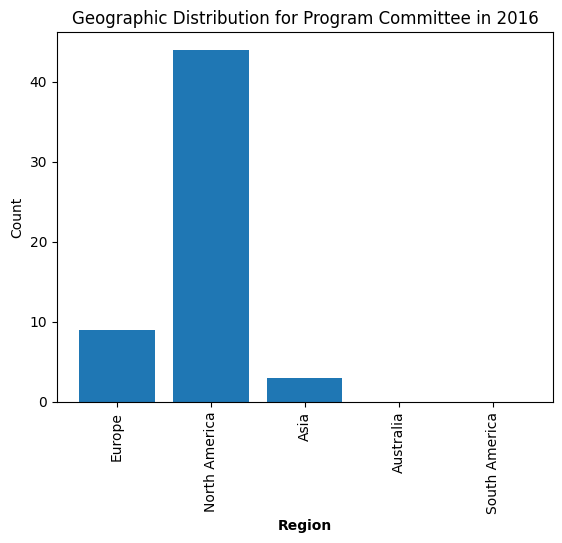

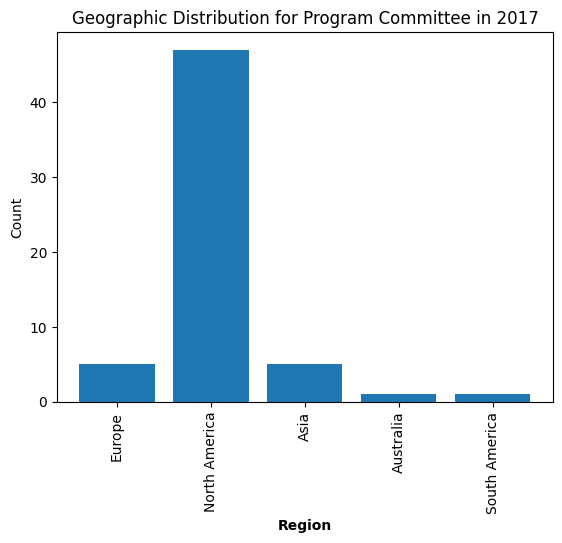

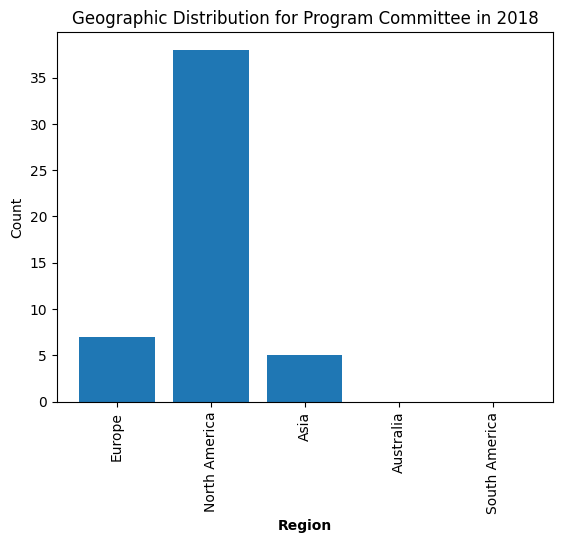

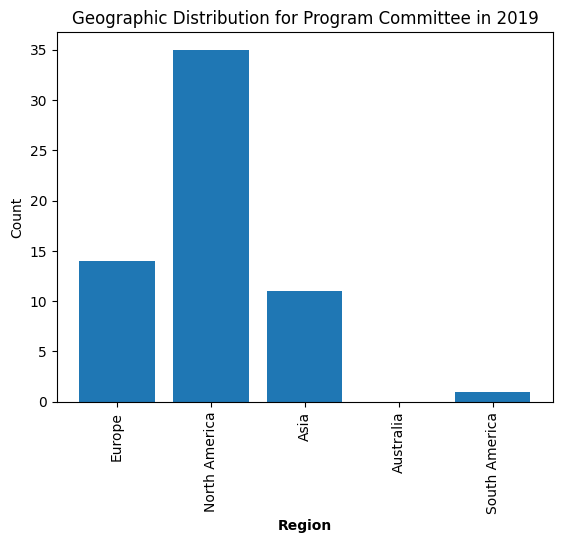

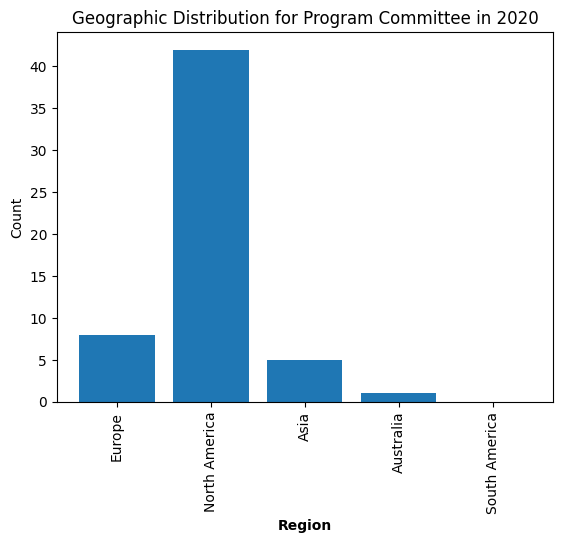

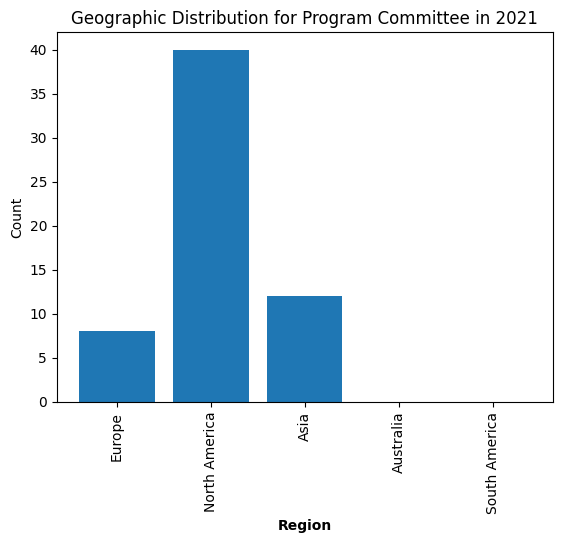

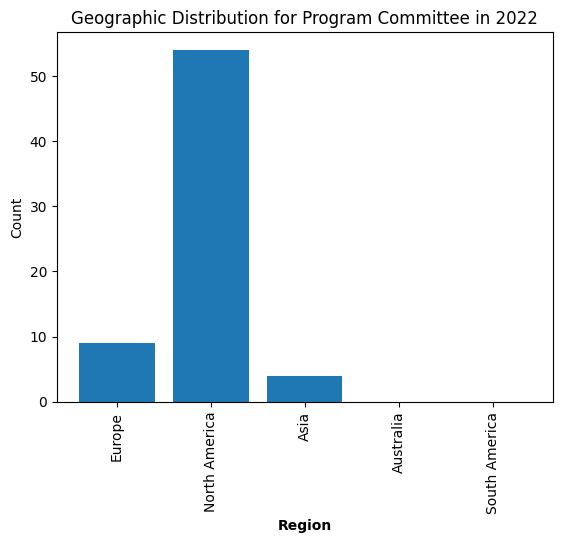

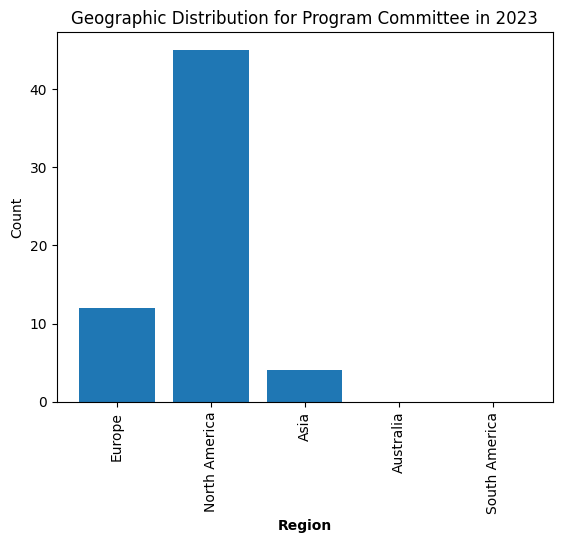

In [39]:
# Continent abbreviations and corresponding full names
continent_names = {
    'NA': 'North America',
    'SA': 'South America',
    'EU': 'Europe',
    'Asia': 'Asia',
    'Australia': 'Australia',
    'Africa': 'Africa'
}

# Get unique committee and year values from the DataFrame
committees = dfFinalUpdated02['committee'].unique()
years = dfFinalUpdated02['year'].unique()

# Loop through each committee
for committee in committees:
    for year in years:
        # Filter the DataFrame for the current committee and year
        df_filtered = dfFinalUpdated02[(dfFinalUpdated02['committee'] == committee) & (dfFinalUpdated02['year'] == year)]

        # Get unique continents from the DataFrame
        all_continents = dfFinalUpdated02['Region'].unique()

        # Calculate region counts
        region_counts = df_filtered['Region'].value_counts().reindex(all_continents, fill_value=0)

        # Create bar chart
        # Map continent abbreviations to full names
        x_labels = [continent_names[continent] for continent in region_counts.index]
        plt.bar(x_labels, region_counts.values)

        # Configure the plot
        plt.xlabel('Region', fontweight='bold')
        plt.ylabel('Count')
        plt.title(f'Geographic Distribution for {committee} Committee in {year}')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=90)

        # Display the plot
        plt.show()


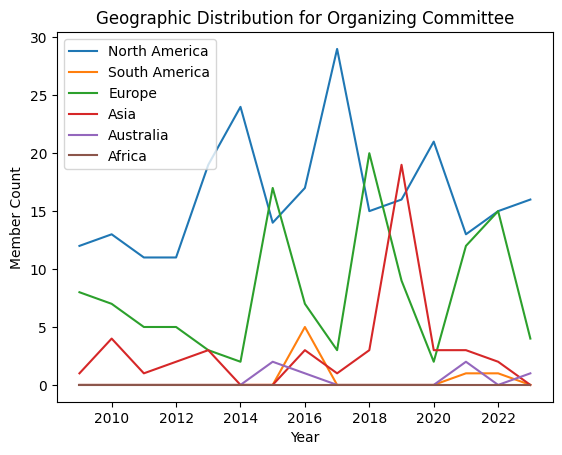

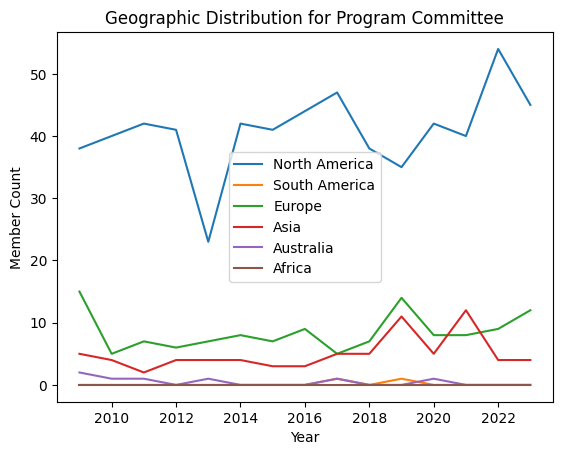

In [40]:
# Get unique committee and year values from the DataFrame
committees = dfFinalUpdated02['committee'].unique()
years = dfFinalUpdated02['year'].unique()

# Create a dictionary to map continent abbreviations to full names
continent_names = {
    'NA': 'North America',
    'SA': 'South America',
    'EU': 'Europe',
    'Asia': 'Asia',
    'Australia': 'Australia',
    'Africa': 'Africa'
}

# Create separate line graphs for each committee
for committee in committees:
    # Create a figure and axis for the current committee
    fig, ax = plt.subplots()

    # Loop through each continent
    for continent in continent_names:
        # Create an empty list to store the counts for each year
        counts = []

        # Loop through each year
        for year in years:
            # Filter the DataFrame for the current committee, continent, and year
            df_filtered = dfFinalUpdated02[(dfFinalUpdated02['committee'] == committee) & (dfFinalUpdated02['Region'] == continent) & (dfFinalUpdated02['year'] == year)]

            # Get the count of members for the current continent and year
            count = len(df_filtered)

            # Append the count to the list
            counts.append(count)

        # Plot the counts as a line graph for the current continent
        ax.plot(years, counts, label=continent_names[continent])

    # Configure the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Member Count')
    ax.set_title(f'Geographic Distribution for {committee} Committee')
    ax.legend()

    # Display the plot
    plt.show()


Writing the final dataframe with all the information compiled into a Google Drive CSV file.

In [41]:
dfFinalUpdated02.to_csv("/content/gdrive/My Drive/Colab Notebooks/save_data/SIGCOMMOutput.csv", sep=',', index=False, encoding='utf-8')